In [8]:
#import scipy.io
#import json
from tqdm import trange
#import math

#import torch.utils.data as data
#from PIL import Image
import numpy as np
from torchvision.datasets import EMNIST
from torchvision.datasets import DatasetFolder
from torchvision import transforms
import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def SQuantization(s,x): 
    
    # s : number of quantization levels
    # x : vector to compress
    
    if s == 0:
        return x
    norm_x = np.linalg.norm(x,2)
    if norm_x == 0:
        return x
    ratio = np.abs(x) / norm_x
    l = np.floor(ratio * s)
    p = ratio * s - l
    sampled = np.random.binomial(1,p)
    qtzt = np.sign(x) * norm_x * (l + sampled) / s
    return qtzt

def com_bits(s,d):
    if s <= np.sqrt(d/2 - np.sqrt(d)):
        return (3 + (3/2) * np.log(2*(s**2 + d)/(s*(s+np.sqrt(d))))) * s*(s+np.sqrt(d)) + 32
    elif s == np.sqrt(d):
        return 2.8*d + 32
    else:
        return ((1/2)*(np.log(1 + (s**2+np.minimum(d,s*np.sqrt(d)))/d) + 1) + 2) * d + 32

In [10]:
train_dataset = EMNIST('./data', split="digits", train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))]))
test_dataset = EMNIST('./data', split="digits", train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))]))

In [11]:
def femnist_star(dataset, num_users):
    """
        Sample non-IID client data from EMNIST dataset -> FEMNIST*
        :param dataset:
        :param num_users:
        :return: dict of image index
    """
    print("Sampling dataset: FEMNIST*")
    np.random.seed(1994)

    dict_users = {i: [] for i in range(num_users)}
    total_len = len(dataset)

    labels = dataset.targets.numpy()
    idxs = np.argsort(labels)

    num_shards, num_imgs = 26 * num_users, total_len // (num_users * 26)

    label_selected = [np.random.choice(26, 20, replace=False) for _ in range(num_users)]

    label_selected_1 = [np.random.choice(label_selected[i], 6, replace=False) for i in range(num_users)]
    for i in range(num_users):
        for j in label_selected[i]:
            ind_pos = np.random.choice(num_users)
            tmp = copy.deepcopy(idxs[j * num_users * num_imgs + ind_pos * num_imgs: j * num_users * num_imgs + (ind_pos + 1) * num_imgs])
            dict_users[i].append(tmp)
        for j in label_selected_1[i]:
            ind_pos = np.random.choice(num_users)
            tmp = copy.deepcopy(idxs[j * num_users * num_imgs + ind_pos * num_imgs: j * num_users * num_imgs + (
                        ind_pos + 1) * num_imgs])
            dict_users[i].append(tmp)

    for i in range(num_users):
        dict_users[i] = np.concatenate(tuple(dict_users[i]), axis=0)
    return dict_users

In [21]:
b = 10 # number of clients
n_max = 100 # maximum number of observations on each client
n_min = 20 # minimum number of observations on each client
np.random.seed(1994)
n = np.random.randint(low=n_min,high=n_max,size=b) # number of observations per client

Text(0.5, 1.0, 'Synthetic$(\\alpha,\\beta)$ dataset with $\\alpha=1$, $\\beta=1$')

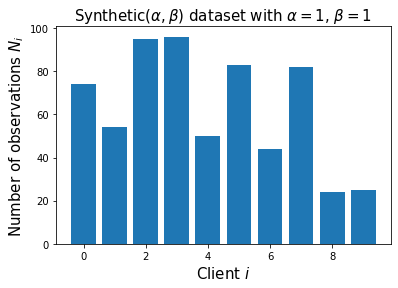

In [22]:
plt.figure()
plt.bar(range(b),n)
plt.xlabel(r'Client $i$',size=15)
plt.ylabel(r'Number of observations $N_i$',size=15)
plt.title(r'Synthetic$(\alpha,\beta)$ dataset with $\alpha=1$, $\beta=1$',size=15)

In [23]:
d = 28*28

dict_users = femnist_star(train_dataset,b)
X = []
y = []
for i in range(b):
    np.random.seed(1994)
    idx_client = np.random.choice(dict_users[i],n[i],replace=False)
    X.append([np.reshape(train_dataset[i][0].numpy(),(d,)) for i in idx_client])
    y.append([train_dataset[i][1] for i in idx_client])

# Define total observations and features
y_tot = np.concatenate(y,axis=0)
X_tot = np.concatenate(X,axis=0)

Sampling dataset: FEMNIST*


In [24]:
def ULA(T_total,T_bi,T,gamma,init):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d,K))
    x = np.zeros((d,K))
    x[:,0] = init
    
    # Initialisation
    Loss = 0
    for k in range(K):
        idx = np.where(y_tot == k)
        A = np.reshape(np.exp(np.dot(X_tot[idx,:],x)),(np.size(idx),K))
        Loss += np.sum(np.log(np.sum(A,axis=1)) - np.dot(X_tot[idx,:],x[:,k]))
        
    loss[0] = Loss + (tau/2) * np.sum(np.linalg.norm(theta[0,:],axis=0)**2) 
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    for t in range(T_total-1):

        for k in range(K):
            idx = np.where(y_tot == k)
            A = np.reshape(np.exp(np.dot(X_tot[idx,:],x)),(np.size(idx),K))
            P = np.exp(np.dot(X_tot[idx,:],x[:,k])) / np.sum(A,axis=1)
            grad = np.dot(np.reshape(X_tot[idx,:],(np.size(idx),d)).T, np.reshape(P - 1,(np.size(idx),))) + tau * x[:,k]
            grad = np.reshape(grad,(d,))
            x[:,k] += - gamma * grad + np.sqrt(2*gamma) * np.random.normal(0,1,d)   
            
            
            
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x

            # Compute the loss
            loss_func = 0
            for k in range(K):
                idx = np.where(y_tot == k)
                A = np.reshape(np.exp(np.dot(X_tot[idx,:],x)),(np.size(idx),K))
                loss_func += np.sum(np.log(np.sum(A,axis=1)) - np.dot(X_tot[idx,:],x[:,k]))

            loss[int((t-T_bi)/thin) + 1] = loss_func + (tau/2) * np.sum(np.linalg.norm(x,axis=0)**2)

            # Compute the accuracy of train set
            proba = np.zeros((len(y_tot),K))
            A = np.reshape(np.exp(np.dot(X_tot,x)),(len(y_tot),K))
            for k in range(K):
                proba[:,k] = np.exp(np.dot(X_tot,x[:,k])) / np.sum(A,axis=1)

            err = proba.argmax(axis=1) - y_tot
            err[err != 0] = 1
            acc[int((t-T_bi)/thin) + 1] = 1 - np.sum(err)/len(err)
    
    return theta, loss, acc

def QLSDpp(T_total,T_bi,T,gamma,p,init,s,L,alpha):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d,K))
    qgrad = np.zeros((b,d))
    h = np.zeros((b,d,K))
    x = np.zeros((d,K))
    z = np.zeros((d,K))
    
    # Initialisation
    Loss = 0
    for k in range(K):
        idx = np.where(y_tot == k)
        A = np.reshape(np.exp(np.dot(X_tot[idx,:],x)),(np.size(idx),K))
        Loss += np.sum(np.log(np.sum(A,axis=1)) - np.dot(X_tot[idx,:],x[:,k]))
        
    loss[0] = Loss + (tau/2) * np.sum(np.linalg.norm(theta[0,:],axis=0)**2) 
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    for t in range(T_total-1):

        for k in range(K):
            
            # Initialisation
            if t == 0:
                x[:,k] = init
            
            # Update the control variate every K iterations
            if t % L == 0: 
                z = x
                
            fullbatch_size = np.size(np.where(y_tot == k))
            
            # For each client in parallel
            for i in range(b): 
                
                X[i] = np.array(X[i])
                
                # Find training data associated to the k-th class
                idx = np.where(np.array(y[i]) == k)
                batch_size = np.size(idx)
                A = np.reshape(np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:],x)),(batch_size,K))
            
                # Compute full gradient at control variate
                P = np.exp(np.dot(X[i][idx,:],z[:,k])) / np.sum(A,axis=1)
                fullgrad_z = np.dot(np.reshape(X[i][idx,:],(batch_size,d)).T, np.reshape(P - 1,(batch_size,))) \
                             + (batch_size/fullbatch_size) * tau * x[:,k]
                fullgrad_z = np.reshape(fullgrad_z,(d,))

                # Compute stochastic gradient based on SVRG scheme
                idx_minibatch = np.random.randint(0, batch_size,size=int(p*batch_size))
                minibatch_size = np.size(idx_minibatch)
                A = np.reshape(np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],x)),(minibatch_size,K))
                P = np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],x[:,k])) / np.sum(A,axis=1)
                grad_theta = np.dot(np.reshape(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],(minibatch_size,d)).T, 
                                    np.reshape(P - 1,(minibatch_size,))) \
                             + (minibatch_size/fullbatch_size) * tau * x[:,k]
                P = np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],z[:,k])) / np.sum(A,axis=1)
                grad_z = np.dot(np.reshape(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],(minibatch_size,d)).T, 
                                    np.reshape(P - 1,(minibatch_size,))) \
                             + (minibatch_size/fullbatch_size) * tau * z[:,k]
                grad = 1/p * (grad_theta - grad_z) + fullgrad_z

                # Quantize the stochastic gradient minus memory term
                qqgrad = SQuantization(s, grad - h[i,:,k])
                qgrad[i,:] = qqgrad + h[i,:,k]
                h[i,:,k] = h[i,:,k] + alpha * qqgrad 
            
            # Update theta on server
            x[:,k] = x[:,k] - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
              
            
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x

            # Compute the loss
            loss_func = 0
            for k in range(K):
                idx = np.where(y_tot == k)
                A = np.reshape(np.exp(np.dot(X_tot[idx,:],x)),(np.size(idx),K))
                loss_func += np.sum(np.log(np.sum(A,axis=1)) - np.dot(X_tot[idx,:],x[:,k]))

            loss[int((t-T_bi)/thin) + 1] = loss_func + (tau/2) * np.sum(np.linalg.norm(x,axis=0)**2)

            # Compute the accuracy of train set
            proba = np.zeros((len(y_tot),K))
            A = np.reshape(np.exp(np.dot(X_tot,x)),(len(y_tot),K))
            for k in range(K):
                proba[:,k] = np.exp(np.dot(X_tot,x[:,k])) / np.sum(A,axis=1)

            err = proba.argmax(axis=1) - y_tot
            err[err != 0] = 1
            acc[int((t-T_bi)/thin) + 1] = 1 - np.sum(err)/len(err)
    
    return theta, loss, acc

def LSDpp(T_total,T_bi,T,gamma,p,init,L):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d,K))
    grad = np.zeros((b,d))
    x = np.zeros((d,K))
    z = np.zeros((d,K))
    
    # Initialisation
    Loss = 0
    for k in range(K):
        idx = np.where(y_tot == k)
        A = np.reshape(np.exp(np.dot(X_tot[idx,:],x)),(np.size(idx),K))
        Loss += np.sum(np.log(np.sum(A,axis=1)) - np.dot(X_tot[idx,:],x[:,k]))
        
    loss[0] = Loss + (tau/2) * np.sum(np.linalg.norm(theta[0,:],axis=0)**2) 
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    for t in range(T_total-1):

        for k in range(K):
            
            # Initialisation
            if t == 0:
                x[:,k] = init
            
            # Update the control variate every K iterations
            if t % L == 0: 
                z = x
                
            fullbatch_size = np.size(np.where(y_tot == k))
            
            # For each client in parallel
            for i in range(b): 
                
                X[i] = np.array(X[i])
                
                # Find training data associated to the k-th class
                idx = np.where(np.array(y[i]) == k)
                batch_size = np.size(idx)
                A = np.reshape(np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:],x)),(batch_size,K))
            
                # Compute full gradient at control variate
                P = np.exp(np.dot(X[i][idx,:],z[:,k])) / np.sum(A,axis=1)
                fullgrad_z = np.dot(np.reshape(X[i][idx,:],(batch_size,d)).T, np.reshape(P - 1,(batch_size,))) \
                             + (batch_size/fullbatch_size) * tau * x[:,k]
                fullgrad_z = np.reshape(fullgrad_z,(d,))

                # Compute stochastic gradient based on SVRG scheme
                idx_minibatch = np.random.randint(0, batch_size,size=int(p*batch_size))
                minibatch_size = np.size(idx_minibatch)
                A = np.reshape(np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],x)),(minibatch_size,K))
                P = np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],x[:,k])) / np.sum(A,axis=1)
                grad_theta = np.dot(np.reshape(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],(minibatch_size,d)).T, 
                                    np.reshape(P - 1,(minibatch_size,))) \
                             + (minibatch_size/fullbatch_size) * tau * x[:,k]
                P = np.exp(np.dot(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],z[:,k])) / np.sum(A,axis=1)
                grad_z = np.dot(np.reshape(X[i][np.reshape(idx,(batch_size,)),:][idx_minibatch,:],(minibatch_size,d)).T, 
                                    np.reshape(P - 1,(minibatch_size,))) \
                             + (minibatch_size/fullbatch_size) * tau * z[:,k]
                grad[i,:] = 1/p * (grad_theta - grad_z) + fullgrad_z
            
            # Update theta on server
            x[:,k] = x[:,k] - gamma * np.sum(grad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
              
            
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x

            # Compute the loss
            loss_func = 0
            for k in range(K):
                idx = np.where(y_tot == k)
                A = np.reshape(np.exp(np.dot(X_tot[idx,:],x)),(np.size(idx),K))
                loss_func += np.sum(np.log(np.sum(A,axis=1)) - np.dot(X_tot[idx,:],x[:,k]))

            loss[int((t-T_bi)/thin) + 1] = loss_func + (tau/2) * np.sum(np.linalg.norm(x,axis=0)**2)

            # Compute the accuracy of train set
            proba = np.zeros((len(y_tot),K))
            A = np.reshape(np.exp(np.dot(X_tot,x)),(len(y_tot),K))
            for k in range(K):
                proba[:,k] = np.exp(np.dot(X_tot,x[:,k])) / np.sum(A,axis=1)

            err = proba.argmax(axis=1) - y_tot
            err[err != 0] = 1
            acc[int((t-T_bi)/thin) + 1] = 1 - np.sum(err)/len(err)
    
    return theta, loss, acc

In [332]:
# Parameters
K = 10
tau = 100
w, v = np.linalg.eig(np.dot(X_tot.T,X_tot))
w = np.max(w.real)
M = w * (1/4) + tau 
gamma = 1/(5*M)
L = 100
p = 0.2
S = [2**2,2**4,2**8,2**16]
omega = [np.minimum(d/s**2,np.sqrt(d)/s) for s in S]
init = np.random.normal(0,1,size=d)
T = 500000

theta1,loss1,acc1 = LSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=p,init=init,L=L)
#theta2,loss2,acc2 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=p,init=init,s=S[0],L=L,alpha=1/(omega[0]+1))
theta3,loss3,acc3 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=p,init=init,s=S[1],L=L,alpha=1/(omega[1]+1))
#theta4,loss4,acc4 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=p,init=init,s=S[2],L=L,alpha=1/(omega[2]+1))
#theta5,loss5,acc5 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=p,init=init,s=S[3],L=L,alpha=1/(omega[3]+1))

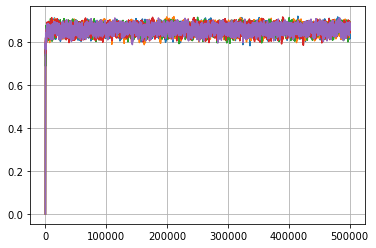

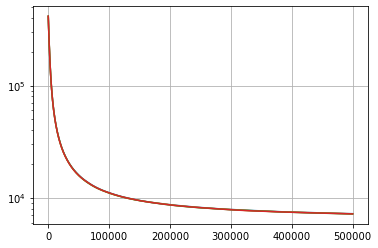

In [73]:
plt.figure()
plt.plot(acc1)
plt.plot(acc2)
plt.plot(acc3)
plt.plot(acc4)
plt.plot(acc5)
plt.grid()

plt.figure()
plt.plot(np.cumsum(loss1[1:])/[1 + t for t in range(T-1)])
plt.plot(np.cumsum(loss2[1:])/[1 + t for t in range(T-1)])
plt.plot(np.cumsum(loss3[1:])/[1 + t for t in range(T-1)])
plt.plot(np.cumsum(loss4[1:])/[1 + t for t in range(T-1)])
plt.grid()
plt.yscale('log')
#plt.ylim(1e4,1.2e4)

In [299]:
N = 200
Tbi = 50000
alpha = 0.01
beta = 0.99
eta1 = np.zeros(N)
eta2 = np.zeros(N)
eta3 = np.zeros(N)
eta4 = np.zeros(N)
eta5 = np.zeros(N)

for i in range(N):
    eta1[i] = np.quantile(loss1[Tbi:],np.linspace(alpha,beta,N)[i])
    eta2[i] = np.quantile(loss2[Tbi:],np.linspace(alpha,beta,N)[i])
    eta3[i] = np.quantile(loss3[Tbi:],np.linspace(alpha,beta,N)[i])
    eta4[i] = np.quantile(loss4[Tbi:],np.linspace(alpha,beta,N)[i])
    eta5[i] = np.quantile(loss5[Tbi:],np.linspace(alpha,beta,N)[i])

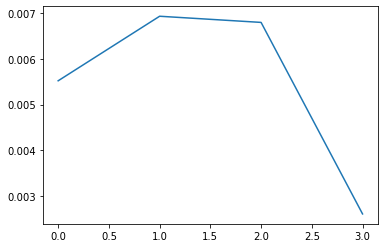

In [298]:
A = np.zeros(4)
A[0] = np.max(np.abs(eta2-eta1)/eta1)
A[1] = np.max(np.abs(eta3-eta1)/eta1)
A[2] = np.max(np.abs(eta4-eta1)/eta1)
A[3] = np.max(np.abs(eta5-eta1)/eta1)
plt.plot(A)

In [316]:
print((32*d)/com_bits(2**4,d))
print((32*d)/com_bits(2**8,d))
print((32*d)/com_bits(2**16,d))

7.630142176060252
6.714773425345526
3.10710776609446


In [326]:
print((np.abs(eta2-eta1)/eta1)[99])
print((np.abs(eta3-eta1)/eta1)[99])
print((np.abs(eta4-eta1)/eta1)[99])
print((np.abs(eta5-eta1)/eta1)[99])

0.0008111079611359241
0.006078454469940216
0.004337765077284434
0.0006908447721037735


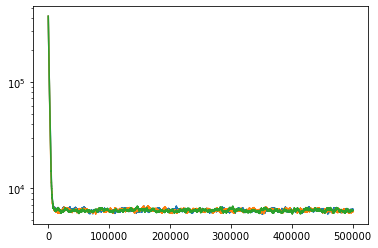

In [331]:
plt.plot(loss1[1:])
plt.plot(loss2[1:])
plt.plot(loss3[1:])
plt.yscale('log')

#### Predictive distribution

In [342]:
X = [np.reshape(test_dataset[i][0].numpy(),(d,)) for i in range(1000)]
y = [test_dataset[i][1] for i in range(1000)]

In [465]:
idx = [0,1,2,31,5,11,15,17]

T = 100000
Tbi = 500000 - T 
K = 10
probaLSD = np.zeros((len(idx),T,K))
probaQLSD = np.zeros((len(idx),T,K))
for t in range(T):
    for i in range(len(idx)):
        AQLSD = np.reshape(np.exp(np.dot(X[idx[i]],theta3[Tbi+t,:])),(1,K))
        ALSD = np.reshape(np.exp(np.dot(X[idx[i]],theta1[Tbi+t,:])),(1,K))
        for k in range(K):
            probaQLSD[i,t,k] = np.exp(np.dot(X[idx[i]],theta3[Tbi+t,:,k])) / np.sum(AQLSD,axis=1)
            probaLSD[i,t,k] = np.exp(np.dot(X[idx[i]],theta1[Tbi+t,:,k])) / np.sum(ALSD,axis=1)

In [466]:
import pandas as pd

indicesMax = np.zeros(len(idx))
for i in range(len(idx)):
    indicesMax[i] = np.reshape(np.where(np.mean(probaQLSD[i,:],axis=0) \
                                        == np.max(np.mean(probaQLSD[i,:],axis=0))),(1,))

# QLSD
df = pd.DataFrame(data=probaQLSD[0,:,int(indicesMax[0])],
                  columns=['Predictive distribution of most probable label'])
df['Algorithm'] = 'QLSD++ 4 bits'
df['observation'] = 0
for i in range(len(idx)-1):
    i += 1
    df1 = pd.DataFrame(data=probaQLSD[i,:,int(indicesMax[i])],
                       columns=['Predictive distribution of most probable label'])
    df1['Algorithm'] = 'QLSD++ 4 bits'
    df1['observation'] = i
    df = pd.concat([df,df1])

dfLSD = pd.DataFrame(data=probaLSD[0,:,int(indicesMax[0])],
                     columns=['Predictive distribution of most probable label'])
dfLSD['Algorithm'] = 'LSD++'
dfLSD['observation'] = 0
for i in range(len(idx)-1):
    i += 1
    df1 = pd.DataFrame(data=probaLSD[i,:,int(indicesMax[i])],
                       columns=['Predictive distribution of most probable label'])
    df1['Algorithm'] = 'LSD++'
    df1['observation'] = i
    dfLSD = pd.concat([dfLSD,df1])

df = pd.concat([df,dfLSD])

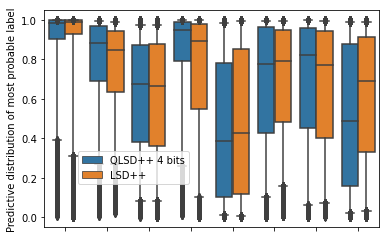

In [514]:
import seaborn as sns

plt.figure()
g = sns.boxplot(x = df['observation'], 
            y = df['Predictive distribution of most probable label'],
            hue = df['Algorithm'],
            whis=[5, 95])
g.set(xticklabels=[])  
g.set(xlabel=None)
plt.legend(bbox_to_anchor=(0.1, 0.35), loc=2, borderaxespad=0.);
plt.savefig('log_reg_predictive_distrib.png',bbox_inches='tight')

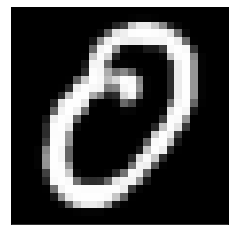

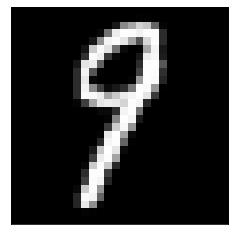

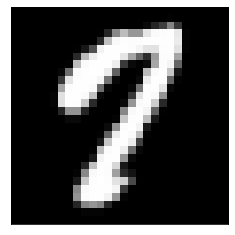

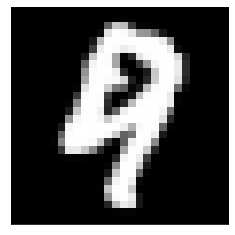

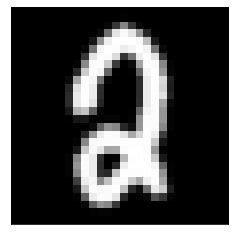

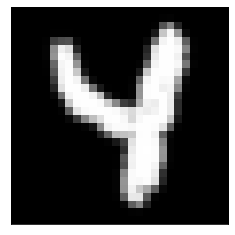

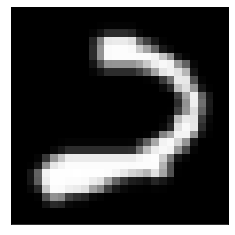

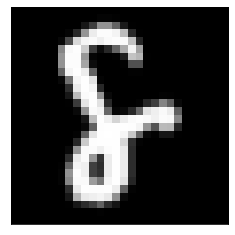

In [516]:
import scipy
from PIL import Image
from PIL import ImageOps

for i in range(len(idx)):  
    plt.figure()
    img = np.fliplr(np.reshape(X[idx[i]],(28,28)))
    tr = scipy.ndimage.rotate(img, 90)
    plt.imshow(tr,cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('digit_%i.png'%i,bbox_inches='tight')

9


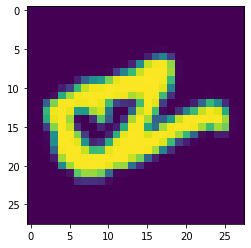

In [464]:
idxx = 31
plt.imshow(np.reshape(X[idxx],(28,28)))
print(y[idxx])

In [350]:
X[999].shape

(784,)

In [368]:
y[0]

[0, 9, 7, 9, 2, 2, 3, 1, 0, 0]